In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Set Dataset Path**

In [3]:
import os

DATASET_PATH = "/content/drive/MyDrive/project_dataset"
print("Dataset Path:", DATASET_PATH)

Dataset Path: /content/drive/MyDrive/project_dataset


**Load Images + Merge Multi-Masks**

In [4]:
import os
import numpy as np
import cv2

IMG_SIZE = 128

def load_stage1_dataset(dataset_path, limit=None):

    images = []
    masks = []

    folders = os.listdir(dataset_path)

    if limit:
        folders = folders[:limit]

    for folder in folders:

        folder_path = os.path.join(dataset_path, folder)

        img_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        # Skip if folders missing
        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            continue

        # ---- Load Image ----
        img_files = os.listdir(img_folder)
        if len(img_files) == 0:
            continue

        img_path = os.path.join(img_folder, img_files[0])

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # ---- Merge Masks ----
        merged_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        mask_files = os.listdir(mask_folder)
        if len(mask_files) == 0:
            continue

        for mask_file in mask_files:
            mask_path = os.path.join(mask_folder, mask_file)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0

            merged_mask += mask

        merged_mask = (merged_mask > 0).astype("float32")
        merged_mask = np.expand_dims(merged_mask, axis=-1)

        images.append(img)
        masks.append(merged_mask)

    # ✅ MUST RETURN
    return np.array(images), np.array(masks)


**Run loader**

In [6]:
X = np.load("/content/drive/MyDrive/X.npy")
Y = np.load("/content/drive/MyDrive/Y.npy")

**Train/Test Split**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

**Build TernausNet (VGG11 Encoder)**

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

**TernausNet Architecture**

In [9]:
def TernausNet(input_shape=(128,128,3)):

    # Pretrained Encoder (VGG)
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Encoder Layers (Skip Connections)
    s1 = base_model.get_layer("block1_conv2").output
    s2 = base_model.get_layer("block2_conv2").output
    s3 = base_model.get_layer("block3_conv3").output
    s4 = base_model.get_layer("block4_conv3").output

    bottleneck = base_model.get_layer("block5_conv3").output

    # Decoder Block Function
    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        return x

    # Decoder Path
    d1 = decoder_block(bottleneck, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output Layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model


**Create Model**

In [10]:
model = TernausNet()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 24,891,137 (94.95 MB)

 Trainable params: 24,891,137 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

**Compile Model**

In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


**Train TernausNet**

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=4
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - accuracy: 0.7006 - loss: 6.5449 - val_accuracy: 0.8450 - val_loss: 0.4279
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.8566 - loss: 0.3887 - val_accuracy: 0.8541 - val_loss: 0.3338
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.8531 - loss: 0.3705 - val_accuracy: 0.8825 - val_loss: 0.2982
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.8694 - loss: 0.3418 - val_accuracy: 0.8762 - val_loss: 0.3793
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.8686 - loss: 0.3220 - val_accuracy: 0.8827 - val_loss: 0.2586
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.8862 - loss: 0.2800 - val_accuracy: 0.8963 - val_loss: 0.2431
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 9s/step - accuracy: 0.8940 - loss: 0.2753 - val_accuracy: 0.8734 - val_loss: 0.2691
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.9049 - loss: 0.2297 - val_accuracy: 0.8921 - v

**Prediction Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


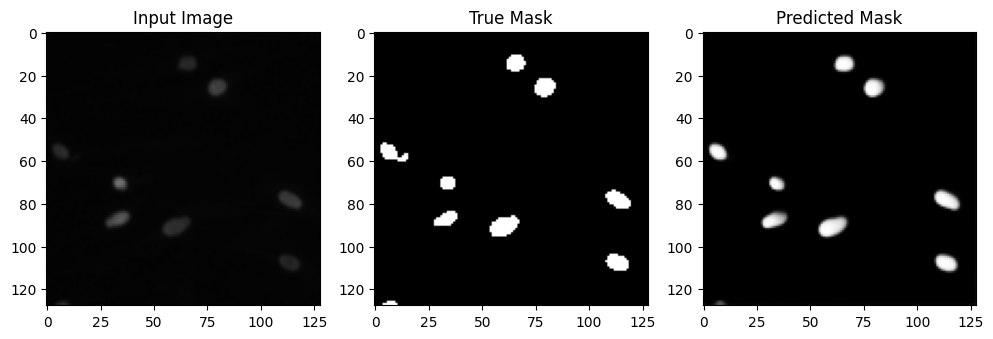

In [13]:
import matplotlib.pyplot as plt

index = 0
pred = model.predict(X_test[index:index+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(X_test[index])

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(Y_test[index].squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


**Save Model**

In [14]:
model.save("/content/drive/MyDrive/ternausnet_model.h5")
print("TernausNet Model Saved Successfully!")

TernausNet Model Saved Successfully!
